# Preprocessing


*   Binarize voltage time series to get spikes
*   Convert spikes to continuous firing rates
*   Split timeseries into trials



In [156]:
import numpy as np
from scipy.signal import convolve
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
import pandas as pd

def binarize(x, threshold):
    """
    Binarize a time series based on upward threshold crossings.

    Parameters
    ----------
    x : array_like
        Input time-series data.
    threshold : float or int
        Threshold value used for binarization. Only upward crossings from below
        to above this threshold are detected as spikes.

    Returns
    -------
    ndarray
        A NumPy array of 0s and 1s representing the binarized time series.
        A 1 indicates an upward threshold crossing at that time point.

    Notes
    -----
    The function converts the input to a NumPy array and detects upward
    threshold crossings to avoid counting the same spike multiple times.
    """
    x = np.asarray(x)
    
    # Create boolean arrays for above/below threshold
    above_threshold = x >= threshold
    
    # Detect upward crossings: was below threshold, now above
    # Shift the array by one position to compare current with previous
    crossings = np.zeros_like(x, dtype=int)
    crossings[1:] = above_threshold[1:] & ~above_threshold[:-1]
    
    return crossings


def smooth(signal, win_size, sampling_freq, std_factor=0.2):
    """
    Smooth a 1-D time series using a Gaussian window and convert to firing rate.

    Parameters
    ----------
    signal : array-like
        Input time-series data (typically a binary spike train).
    win_size : float
        Window size in seconds.
    sampling_freq : float
        Samples per second (Hz).
    std_factor : float
        Fraction of window length used as the Gaussian standard deviation.
        Typical values: 0.1–0.3.

    Returns
    -------
    smoothed : ndarray
        Smoothed signal in units of spikes per second (Hz).
    
    Notes
    -----
    When applied to a binary spike train, this function returns the estimated
    instantaneous firing rate in Hz (spikes/second).
    """

    # Convert window size (seconds) → samples
    win_len = int(np.round(win_size * sampling_freq))
    if win_len < 3:
        raise ValueError("Window size too small after converting to samples.")

    # Ensure window length is odd for symmetric convolution
    if win_len % 2 == 0:
        win_len += 1

    # Gaussian σ (in samples)
    std = win_len * std_factor

    # Create the Gaussian window
    win = gaussian(win_len, std=std)

    # Normalize window to preserve signal scale
    win /= win.sum()

    # Convolve with same length output
    smoothed = convolve(signal, win, mode='same')
    
    # Convert to spikes per second by multiplying by sampling frequency
    # This is because smoothed gives average spikes per sample, and 
    # (spikes/sample) * (samples/second) = spikes/second
    smoothed = smoothed * sampling_freq

    return smoothed

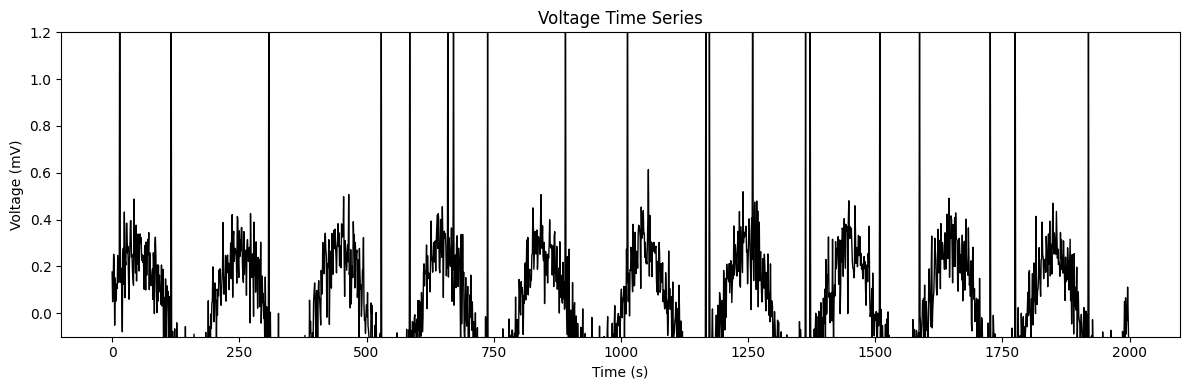

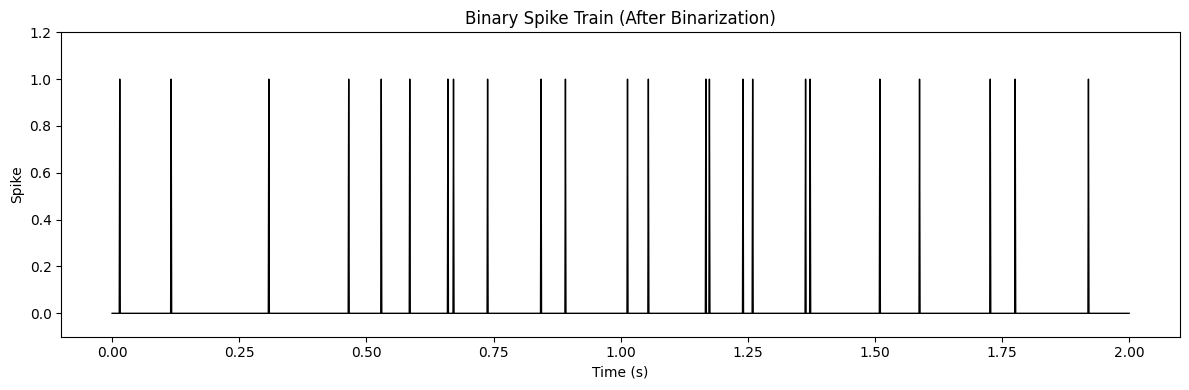

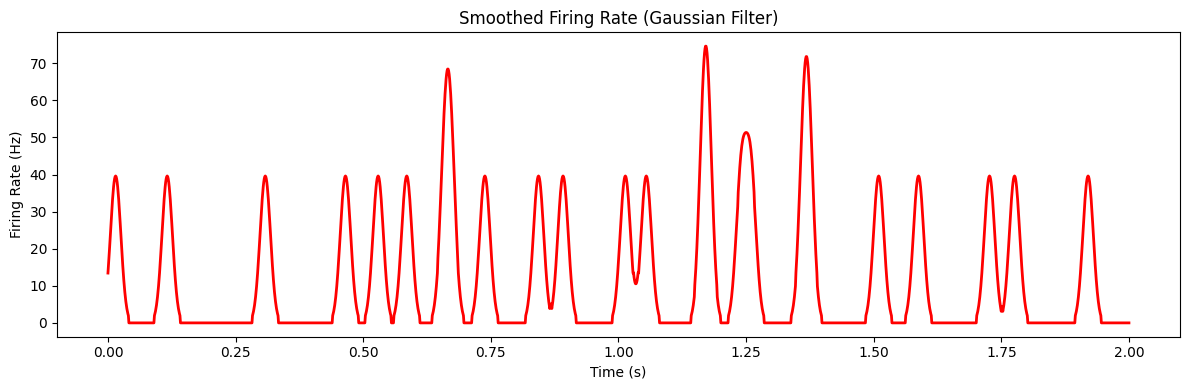

In [157]:
# ===== Generate random voltage time series =====
np.random.seed(0)
sampling_freq = 1000  # Hz
duration = 2.0        # seconds
t = np.linspace(0, duration, int(duration * sampling_freq))

# A noisy subthreshold membrane voltage with occasional spikes
signal = 0.3 * np.sin(2*np.pi*5*t) + 0.1*np.random.randn(len(t))
signal[np.random.choice(len(t), 20, replace=False)] += 1.5  # add artificial spikes

# ===== Step 1: Binarize (spike detection) =====
threshold = 0.5
spikes = binarize(signal, threshold)

# ===== Step 2: Smooth spike train to get firing rate =====
firing_rate = smooth(spikes, win_size=0.05, sampling_freq=sampling_freq)

# ===== Plot 0: Voltage time series =====
plt.figure(figsize=(12,4))
plt.plot(signal, color='black', linewidth=1)
plt.title("Voltage Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.ylim(-0.1, 1.2)
plt.tight_layout()
plt.show()

# ===== Plot 1: Binary spike train =====
plt.figure(figsize=(12,4))
plt.plot(t, spikes, color='black', linewidth=1)
plt.title("Binary Spike Train (After Binarization)")
plt.xlabel("Time (s)")
plt.ylabel("Spike")
plt.ylim(-0.1, 1.2)
plt.tight_layout()
plt.show()

# ===== Plot 2: Firing-rate estimate =====
plt.figure(figsize=(12,4))
plt.plot(t, firing_rate, color='red', linewidth=2)
plt.title("Smoothed Firing Rate (Gaussian Filter)")
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate (Hz)")
plt.tight_layout()
plt.show()

# Real data

In [158]:
# read csv
csv_path = r'data/FirstExp-minusfivetofive-420REALREAL-FORREALTHISTIME2025-01-08T16_23_39_chunk_10_20.csv'
data = pd.read_csv(csv_path)
data.head()

Unnamed: 0       TTL     Ephys
0           0  0.280316  0.007547
1           1  0.292554  0.000140
2           2  0.308334  0.015276
3           3  0.299317 -0.003402
4           4  0.282571  0.003361

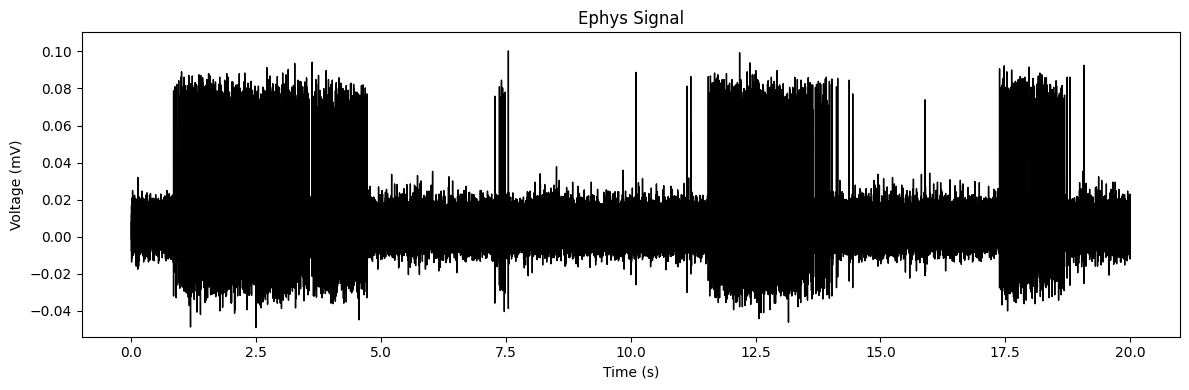

In [159]:
ephys_signal = data['Ephys'].values

fs = 25000 # 25 kHz
time = np.arange(len(ephys_signal)) / fs

# plot ephys signal
plt.figure(figsize=(12,4))
plt.plot(time[:fs*20], ephys_signal[:fs*20], color='black', linewidth=1)
plt.title("Ephys Signal")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.ylim(np.min(ephys_signal[:fs*20])*1.1, np.max(ephys_signal[:fs*20])*1.1)
plt.tight_layout()
plt.show()


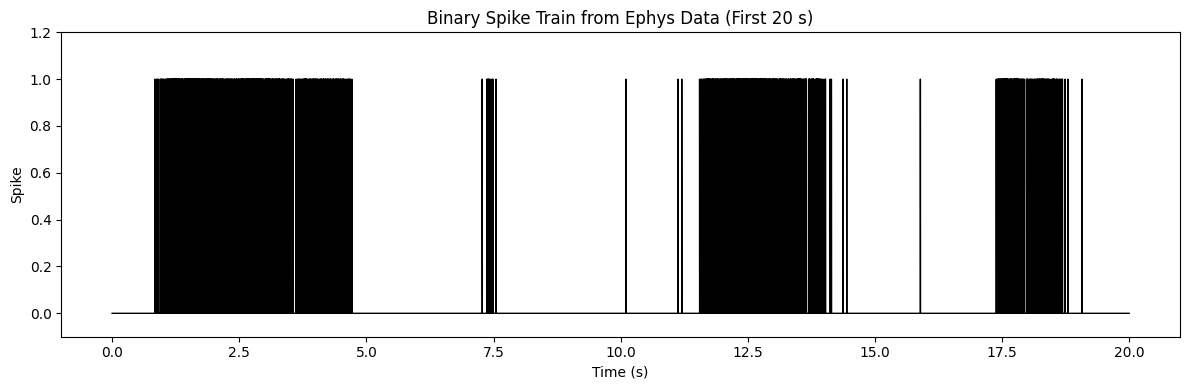

In [160]:
# binarize Ephys data
threshold = 0.05  # set an appropriate threshold based on data characteristics
ephys_spikes = binarize(ephys_signal, threshold)

time = np.arange(len(ephys_signal)) / fs

# plot only first 10 s
plt.figure(figsize=(12, 4))
plt.plot(time[:fs*20], ephys_spikes[:fs*20], color='black', linewidth=1)
plt.title("Binary Spike Train from Ephys Data (First 20 s)")
plt.xlabel("Time (s)")
plt.ylabel("Spike")
plt.ylim(-0.1, 1.2)
plt.tight_layout()
plt.show()

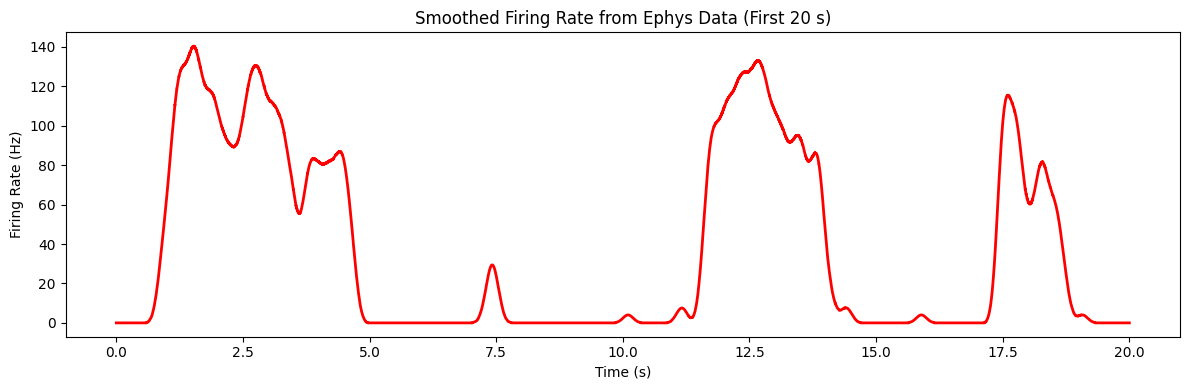

In [161]:
# plot the smoothed firing rate from ephys spikes
ephys_firing_rate = smooth(ephys_spikes, win_size=0.5, sampling_freq=fs)
plt.figure(figsize=(12,4))
plt.plot(time[:fs*20], ephys_firing_rate[:fs*20], color='red', linewidth=2)
plt.title("Smoothed Firing Rate from Ephys Data (First 20 s)")
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate (Hz)")
plt.tight_layout()
plt.show()

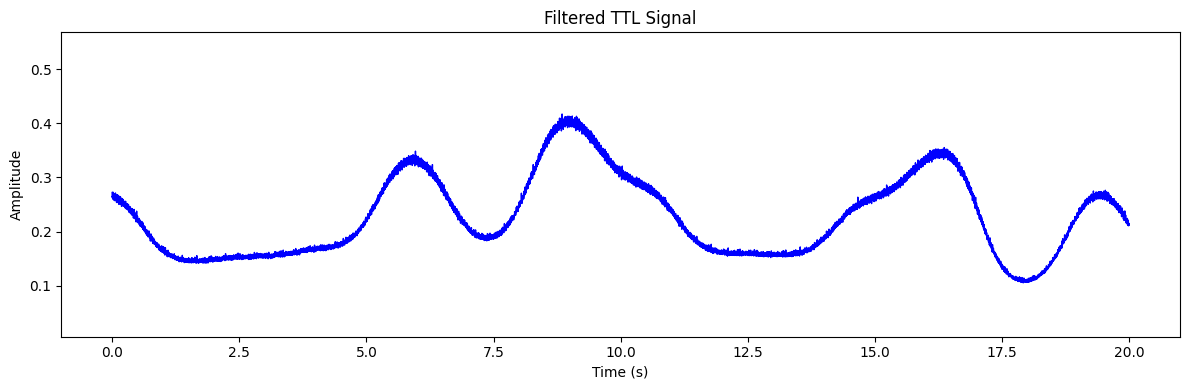

In [162]:
# filter TTL signal
from scipy.signal import filtfilt, butter

TTL = data['TTL'].values

fs = 25000 # sampling frequency of 25kHz
cutoff = 200  # 200
order = 4
b, a = butter(order, cutoff / (fs/2), btype='low') # fs/2 is the Nyquist frequency; need to normalize cutoff frequency between 0 and 1
filtered_TTL = filtfilt(b, a, TTL)

# plot filtered TTL signal
time = np.arange(len(filtered_TTL)) / fs
plt.figure(figsize=(12,4))
plt.plot(time[:fs*20], filtered_TTL[:fs*20], color='blue', linewidth=1)
plt.title("Filtered TTL Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(np.min(filtered_TTL)*1.1, np.max(filtered_TTL)*1.1)
plt.tight_layout()
plt.show()


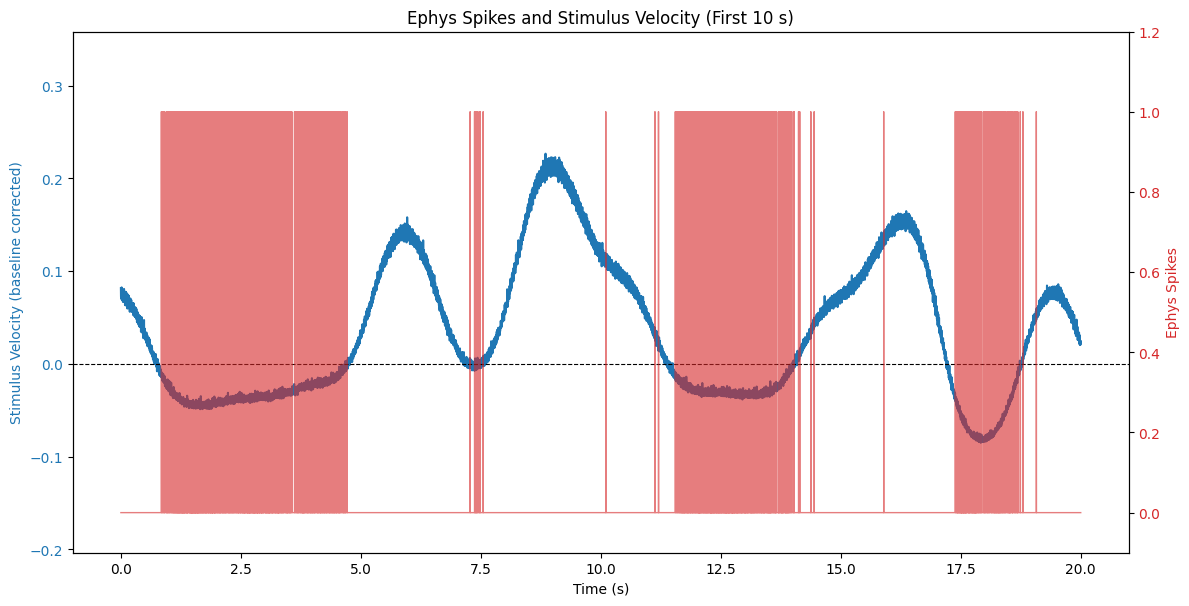

In [163]:
baseline = np.median(filtered_TTL)  # or np.mean(filtered_TTL)
bipolar_signal = filtered_TTL - baseline

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stimulus on first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Stimulus Velocity (baseline corrected)', color=color)
ax1.plot(time[:fs*20], bipolar_signal[:fs*20], color=color)
# add black line at zero
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(np.min(bipolar_signal)*1.1, np.max(bipolar_signal)*1.1)
# Plot ephys spikes on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Ephys Spikes', color=color)
ax2.plot(time[:fs*20], ephys_spikes[:fs*20], color=color, alpha = 0.6, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.1, 1.2)
fig.tight_layout()
plt.title("Ephys Spikes and Stimulus Velocity (First 10 s)")
plt.show()


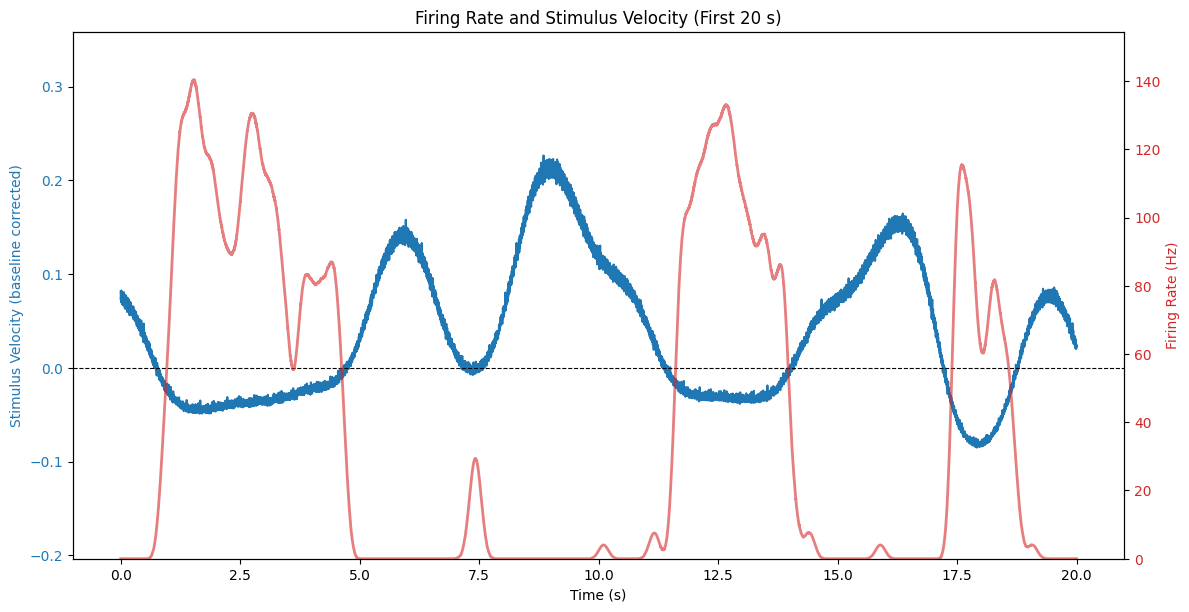

In [164]:
# get spike rate
fs = 25000
firing_rate = smooth(ephys_spikes, win_size=0.5, sampling_freq=fs)

# plot firing rate and stimulus
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot stimulus on first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Stimulus Velocity (baseline corrected)', color=color)
ax1.plot(time[:fs*20], bipolar_signal[:fs*20], color=color)
# add black line at zero
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(np.min(bipolar_signal)*1.1, np.max(bipolar_signal)*1.1)
# Plot firing rate on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Firing Rate (Hz)', color=color)
ax2.plot(time[:fs*20], firing_rate[:fs*20], color=color, alpha=0.6, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.max(firing_rate[:fs*20])*1.1)  # Start from 0 for firing rate
fig.tight_layout()
plt.title("Firing Rate and Stimulus Velocity (First 20 s)")
plt.show()

# find trials in the 10min recording
# reproduce figure 1

In [165]:
# Alternative approach: Look for repeating patterns using autocorrelation
from scipy.signal import correlate

# Downsample for faster computation
downsample_factor = 250  # From 25kHz to 100Hz
downsampled_signal = bipolar_signal[::downsample_factor]
downsampled_time = time[::downsample_factor]
downsampled_fs = fs / downsample_factor

# Compute autocorrelation
autocorr = correlate(downsampled_signal, downsampled_signal, mode='full')
autocorr = autocorr[len(autocorr)//2:]  # Keep only positive lags
lags = np.arange(len(autocorr)) / downsampled_fs

# Find peaks in autocorrelation (these indicate repeating periods)
peaks, properties = find_peaks(autocorr, height=np.max(autocorr)*0.1, distance=int(10*downsampled_fs))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot autocorrelation
ax1.plot(lags[:len(lags)//4], autocorr[:len(lags)//4], linewidth=1)  # Show first quarter
ax1.plot(lags[peaks], autocorr[peaks], 'rx', markersize=10, label='Detected peaks')
ax1.set_xlabel('Lag (seconds)', fontsize=12)
ax1.set_ylabel('Autocorrelation', fontsize=12)
ax1.set_title('Autocorrelation - Shows Repeating Periods', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot downsampled signal with detected period markers
ax2.plot(downsampled_time, downsampled_signal, linewidth=0.5)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Stimulus Velocity', fontsize=12)
ax2.set_title('Downsampled TTL Signal', fontsize=14)
ax2.axhline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

if len(peaks) > 0:
    print(f"\nDetected {len(peaks)} peaks in autocorrelation")
    print(f"Potential trial periods (seconds): {lags[peaks[:10]]}")  # Show first 10
    if len(peaks) > 1:
        dominant_period = lags[peaks[1]]  # First peak after zero-lag
        print(f"\nMost likely trial period: {dominant_period:.2f} seconds")
        print(f"This suggests approximately {len(bipolar_signal)/fs / dominant_period:.0f} trials in the recording")
else:
    print("No clear repeating pattern found via autocorrelation")


Detected 2 peaks in autocorrelation
Potential trial periods (seconds): [5.0000e-02 1.8151e+02]

Most likely trial period: 181.51 seconds
This suggests approximately 3 trials in the recording


If trial period is 20.0s, we expect 30 complete trials
Plus potentially one incomplete trial at the end

Trial 1: 0.0s to 20.0s (duration: 20.0s)
Trial 2: 20.0s to 40.0s (duration: 20.0s)
Trial 3: 40.0s to 60.0s (duration: 20.0s)
Trial 4: 60.0s to 80.0s (duration: 20.0s)
Trial 5: 80.0s to 100.0s (duration: 20.0s)
Trial 6: 100.0s to 120.0s (duration: 20.0s)
Trial 7: 120.0s to 140.0s (duration: 20.0s)
Trial 8: 140.0s to 160.0s (duration: 20.0s)
Trial 9: 160.0s to 180.0s (duration: 20.0s)
Trial 10: 180.0s to 200.0s (duration: 20.0s)
Trial 11: 200.0s to 220.0s (duration: 20.0s)
Trial 12: 220.0s to 240.0s (duration: 20.0s)
Trial 13: 240.0s to 260.0s (duration: 20.0s)
Trial 14: 260.0s to 280.0s (duration: 20.0s)
Trial 15: 280.0s to 300.0s (duration: 20.0s)
Trial 16: 300.0s to 320.0s (duration: 20.0s)
Trial 17: 320.0s to 340.0s (duration: 20.0s)
Trial 18: 340.0s to 360.0s (duration: 20.0s)
Trial 19: 360.0s to 380.0s (duration: 20.0s)
Trial 20: 380.0s to 400.0s (duration: 20.0s)
Trial 21: 400.

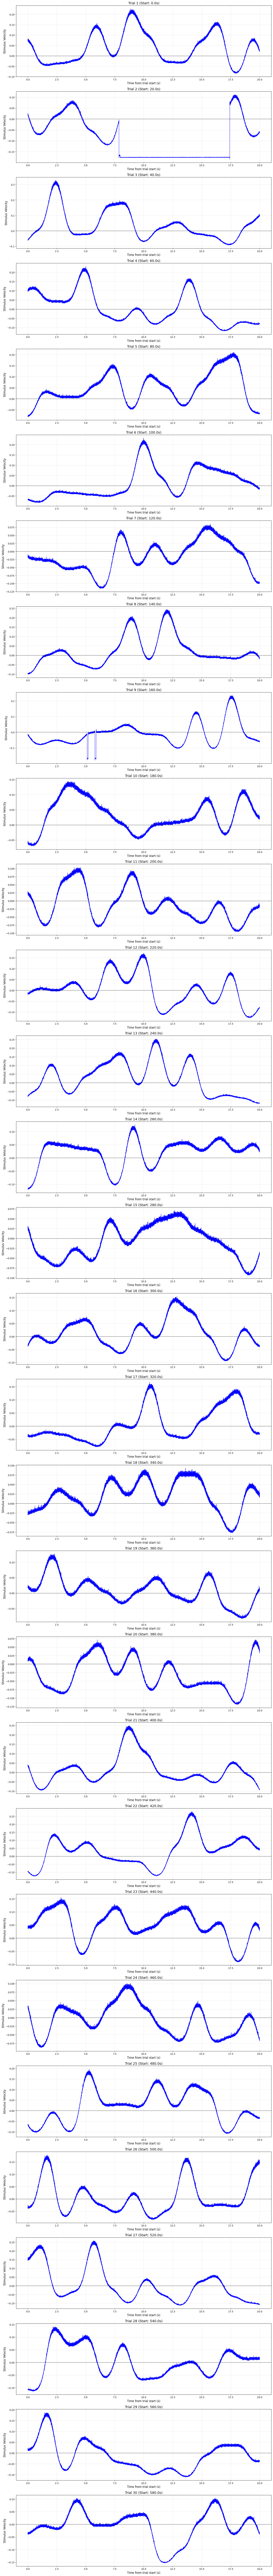

In [166]:
# Let's verify by looking at the signal split into ~181 second chunks
trial_period = 20  # 181.51 seconds
n_expected_trials = int(len(bipolar_signal) / fs / trial_period)

print(f"If trial period is {trial_period:.1f}s, we expect {n_expected_trials} complete trials")
print(f"Plus potentially one incomplete trial at the end\n")

# Manually segment the data based on this period
manual_trial_starts = []
manual_trial_ends = []

for i in range(n_expected_trials + 1):  # +1 to catch any partial trial at end
    start_sec = i * trial_period
    end_sec = (i + 1) * trial_period
    
    start_idx = int(start_sec * fs)
    end_idx = min(int(end_sec * fs), len(bipolar_signal))
    
    if start_idx < len(bipolar_signal):
        manual_trial_starts.append(start_idx)
        manual_trial_ends.append(end_idx)
        duration = (end_idx - start_idx) / fs
        print(f"Trial {i+1}: {start_sec:.1f}s to {end_sec:.1f}s (duration: {duration:.1f}s)")

# Visualize these segments
fig, axes = plt.subplots(len(manual_trial_starts), 1, figsize=(16, 5*len(manual_trial_starts)))

if len(manual_trial_starts) == 1:
    axes = [axes]

for i, (start, end) in enumerate(zip(manual_trial_starts, manual_trial_ends)):
    trial_time = (np.arange(end - start) / fs)
    axes[i].plot(trial_time, bipolar_signal[start:end], color='blue', linewidth=1)
    axes[i].axhline(0, color='black', linewidth=1, linestyle='--')
    axes[i].set_xlabel('Time from trial start (s)', fontsize=12)
    axes[i].set_ylabel('Stimulus Velocity', fontsize=12)
    axes[i].set_title(f'Trial {i+1} (Start: {start/fs:.1f}s)', fontsize=14)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [167]:
# Faster statistics for each trial
print("=" * 70)
print("TRIAL STATISTICS")
print("=" * 70)

for i, (start, end) in enumerate(zip(manual_trial_starts, manual_trial_ends)):
    trial_signal = bipolar_signal[start:end]
    
    # Basic statistics (very fast)
    mean_val = np.mean(trial_signal)
    std_val = np.std(trial_signal)
    duration = (end - start) / fs
    
    # Temporal correlation time (optimized)
    # Downsample heavily and only compute autocorr up to 5 seconds
    downsample = 500  # More aggressive downsampling (25kHz -> 50Hz)
    max_lag_sec = 5.0
    
    sig_down = trial_signal[::downsample]
    fs_down = fs / downsample
    max_lag_samples = int(max_lag_sec * fs_down)
    
    # Normalize
    sig_norm = (sig_down - np.mean(sig_down)) / np.std(sig_down)
    
    # Only compute autocorr up to max_lag
    autocorr = np.correlate(sig_norm[:max_lag_samples*2], sig_norm[:max_lag_samples*2], mode='full')
    autocorr = autocorr[len(autocorr)//2:len(autocorr)//2 + max_lag_samples]
    autocorr = autocorr / autocorr[0]
    
    # Find correlation time
    lags = np.arange(len(autocorr)) / fs_down
    crossing = np.where(autocorr < 1/np.e)[0]
    tau = lags[crossing[0]] if len(crossing) > 0 else np.nan
    
    print(f"\nTrial {i+1} ({start/fs:.1f}s - {end/fs:.1f}s):")
    print(f"  Mean: {mean_val:.6f}")
    print(f"  SD:   {std_val:.6f}")
    print(f"  τ:    {tau:.4f} s")

print("\n" + "=" * 70)

TRIAL STATISTICS

Trial 1 (0.0s - 20.0s):
  Mean: 0.035844
  SD:   0.073387
  τ:    1.0200 s

Trial 2 (20.0s - 40.0s):
  Mean: -0.094507
  SD:   0.090333
  τ:    2.1600 s

Trial 3 (40.0s - 60.0s):
  Mean: 0.035203
  SD:   0.091414
  τ:    0.9200 s

Trial 4 (60.0s - 80.0s):
  Mean: 0.002831
  SD:   0.084511
  τ:    1.2600 s

Trial 5 (80.0s - 100.0s):
  Mean: 0.048819
  SD:   0.069446
  τ:    0.8600 s

Trial 6 (100.0s - 120.0s):
  Mean: 0.011934
  SD:   0.070761
  τ:    1.3200 s

Trial 7 (120.0s - 140.0s):
  Mean: -0.016677
  SD:   0.046379
  τ:    0.9800 s

Trial 8 (140.0s - 160.0s):
  Mean: 0.020042
  SD:   0.074625
  τ:    1.1600 s

Trial 9 (160.0s - 180.0s):
  Mean: -0.013051
  SD:   0.070891
  τ:    2.0200 s

Trial 10 (180.0s - 200.0s):
  Mean: 0.032522
  SD:   0.052226
  τ:    1.4200 s

Trial 11 (200.0s - 220.0s):
  Mean: -0.014774
  SD:   0.050527
  τ:    0.9800 s

Trial 12 (220.0s - 240.0s):
  Mean: 0.000711
  SD:   0.067919
  τ:    0.9400 s

Trial 13 (240.0s - 260.0s):
  Mean: 0

# Analysis

In [168]:
# Ignoring trials: # Plot response as function of velocity 
    # discretize velocities in bins
    # map each velocity bin to 30ms earlier
# Plot velocity vs response 
# Try average velocity vs time with average firing rate vs time 

In [169]:
# ========== FIGURE 1B: Velocity vs Response (Ignoring trial structure) ==========
print("="*70)
print("FIGURE 1B: VELOCITY VS RESPONSE")
print("="*70)

# Parameters
response_delay_ms = 30  # Look at velocity 30ms before response
fs = 25000  # sampling frequency

# Calculate delay in samples
delay_samples = int((response_delay_ms / 1000) * fs)

print(f"\nResponse delay: {response_delay_ms}ms ({delay_samples} samples)")

# Align firing rate with velocity from 30ms earlier
# For each time point t, pair firing_rate[t] with bipolar_signal[t - delay_samples]
# We need to ensure we don't go negative in indexing

# Create aligned arrays (skip first delay_samples points)
velocity_aligned = bipolar_signal[:-delay_samples]  # velocity from earlier times
response_aligned = firing_rate[delay_samples:]       # response at later times

print(f"Aligned {len(velocity_aligned)} velocity-response pairs")
print(f"Velocity range: [{velocity_aligned.min():.4f}, {velocity_aligned.max():.4f}]")
print(f"Response range: [{response_aligned.min():.2f}, {response_aligned.max():.2f}] Hz")

# Create figure with two panels
fig, (ax_scatter, ax_binned) = plt.subplots(1, 2, figsize=(16, 6))

# ========== PANEL 1: Scatter plot (raw data) ==========
# Downsample for visualization (plotting 15M points is slow)
downsample_factor = 100
velocity_plot = velocity_aligned[::downsample_factor]
response_plot = response_aligned[::downsample_factor]

ax_scatter.plot(velocity_plot, response_plot, 'o', 
                markersize=1, alpha=0.1, color='gray',
                markerfacecolor='gray', rasterized=True)
ax_scatter.set_xlim(-.15, 0.35)

ax_scatter.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax_scatter.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax_scatter.set_title('(a) Velocity vs Response - Raw Data', fontsize=13, fontweight='bold')
ax_scatter.grid(True, alpha=0.3)
ax_scatter.set_ylim(0, 1000)
ax_scatter.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax_scatter.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

# ========== PANEL 2: Binned average ==========
# Bin velocities and compute average response in each bin
n_bins = 50
velocity_bins = np.linspace(velocity_aligned.min(), velocity_aligned.max(), n_bins + 1)
response_binned = []
velocity_centers = []
response_std = []

for i in range(n_bins):
    mask = (velocity_aligned >= velocity_bins[i]) & (velocity_aligned < velocity_bins[i+1])
    n_points = np.sum(mask)
    
    if n_points > 100:  # Only include bins with sufficient data
        response_binned.append(np.mean(response_aligned[mask]))
        response_std.append(np.std(response_aligned[mask]))
        velocity_centers.append((velocity_bins[i] + velocity_bins[i+1]) / 2)

response_binned = np.array(response_binned)
response_std = np.array(response_std)
velocity_centers = np.array(velocity_centers)

print(f"\nBinned into {len(velocity_centers)} bins with sufficient data (>100 points each)")

# Plot binned average with error bars (showing SEM)
sem = response_std / np.sqrt([np.sum((velocity_aligned >= velocity_bins[i]) & 
                                      (velocity_aligned < velocity_bins[i+1])) 
                               for i in range(n_bins) if 
                               np.sum((velocity_aligned >= velocity_bins[i]) & 
                                      (velocity_aligned < velocity_bins[i+1])) > 100])

ax_binned.errorbar(velocity_centers, response_binned, yerr=sem,
                   fmt='o-', markersize=6, color='black', linewidth=2,
                   markerfacecolor='black', capsize=3, label='Binned average ± SEM')

ax_binned.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax_binned.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax_binned.set_xlim(-.15, 0.35)
ax_binned.set_title('(b) Input-Output Relation r(s)', fontsize=13, fontweight='bold')
ax_binned.grid(True, alpha=0.3)
ax_binned.legend(fontsize=10)
ax_binned.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax_binned.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax_binned.set_ylim(0, 1000)

plt.tight_layout()
plt.savefig('figure_1b_velocity_vs_response.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 1b complete!")
print("  Saved to: figure_1b_velocity_vs_response.png")

FIGURE 1B: VELOCITY VS RESPONSE

Response delay: 30ms (750 samples)
Aligned 14999250 velocity-response pairs
Velocity range: [-0.1851, 0.3257]


Response range: [-0.00, 257.88] Hz

Binned into 50 bins with sufficient data (>100 points each)



✅ Figure 1b complete!
  Saved to: figure_1b_velocity_vs_response.png


# Analysis trials

STIMULUS GROUP IDENTIFICATION (Simple Distance Method)

Target SD values: 0.04 and 0.08

LOW SD GROUP (closer to 0.04):
  Number of trials: 12
  Mean SD: 0.048746 ± 0.005734
  Range: [0.039531, 0.058596]
  Trials: [7, 10, 11, 14, 15, 16, 18, 19, 20, 23, 24, 30]

HIGH SD GROUP (closer to 0.08):
  Number of trials: 18
  Mean SD: 0.076156 ± 0.011160
  Range: [0.060112, 0.096185]
  Trials: [1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 17, 21, 22, 25, 26, 27, 28, 29]

Ratio of means: 1.56x


/home/maduarte/flygang/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


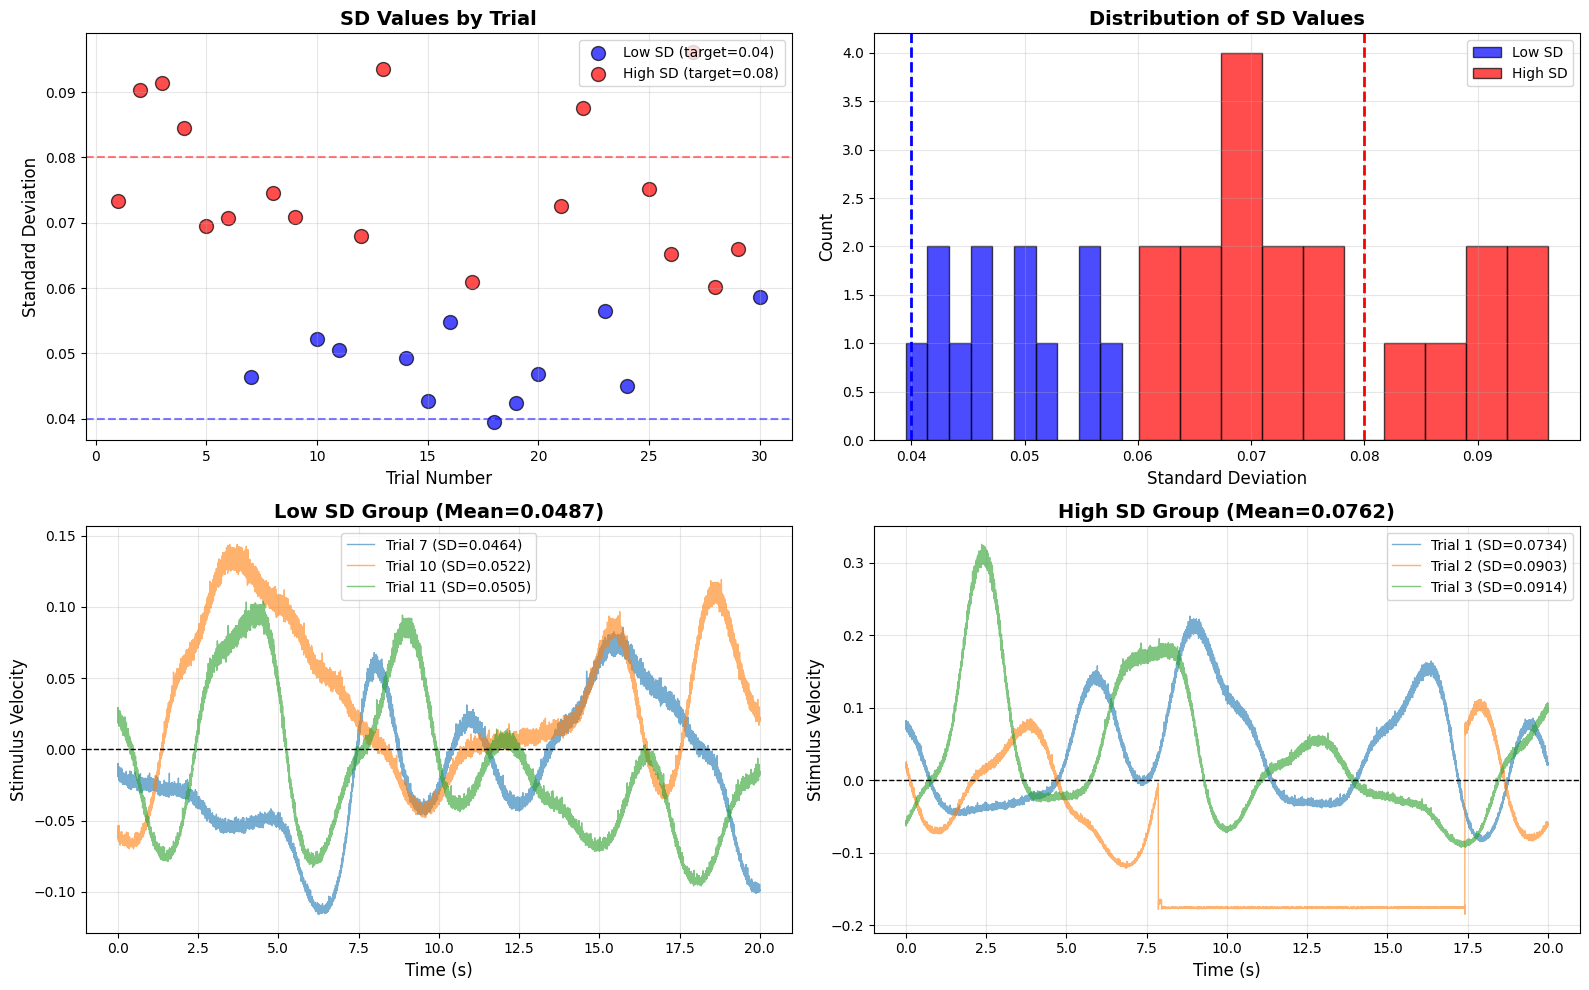

In [170]:
# Simple approach: Identify trials closest to target SD values
target_sd_low = 0.04
target_sd_high = 0.08

# Extract SD values from trials
sd_values = []
trial_indices = []

for i, (start, end) in enumerate(zip(manual_trial_starts, manual_trial_ends)):
    trial_signal = bipolar_signal[start:end]
    std_val = np.std(trial_signal)
    sd_values.append(std_val)
    trial_indices.append(i + 1)  # 1-indexed

sd_values = np.array(sd_values)
trial_indices = np.array(trial_indices)

# Classify trials based on which target they're closer to
low_sd_group = []
high_sd_group = []

for i, sd in enumerate(sd_values):
    dist_to_low = abs(sd - target_sd_low)
    dist_to_high = abs(sd - target_sd_high)
    
    if dist_to_low < dist_to_high:
        low_sd_group.append(i)
    else:
        high_sd_group.append(i)

low_sd_trials = trial_indices[low_sd_group]
high_sd_trials = trial_indices[high_sd_group]
low_sd_values = sd_values[low_sd_group]
high_sd_values = sd_values[high_sd_group]

print("="*70)
print("STIMULUS GROUP IDENTIFICATION (Simple Distance Method)")
print("="*70)
print(f"\nTarget SD values: {target_sd_low} and {target_sd_high}")
print(f"\nLOW SD GROUP (closer to {target_sd_low}):")
print(f"  Number of trials: {len(low_sd_trials)}")
print(f"  Mean SD: {np.mean(low_sd_values):.6f} ± {np.std(low_sd_values):.6f}")
print(f"  Range: [{np.min(low_sd_values):.6f}, {np.max(low_sd_values):.6f}]")
print(f"  Trials: {sorted(low_sd_trials.tolist())}")

print(f"\nHIGH SD GROUP (closer to {target_sd_high}):")
print(f"  Number of trials: {len(high_sd_trials)}")
print(f"  Mean SD: {np.mean(high_sd_values):.6f} ± {np.std(high_sd_values):.6f}")
print(f"  Range: [{np.min(high_sd_values):.6f}, {np.max(high_sd_values):.6f}]")
print(f"  Trials: {sorted(high_sd_trials.tolist())}")

print(f"\nRatio of means: {np.mean(high_sd_values) / np.mean(low_sd_values):.2f}x")
print("="*70)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top left: SD values with grouping
axes[0, 0].scatter(low_sd_trials, low_sd_values, c='blue', s=100, alpha=0.7, 
                   edgecolors='black', label=f'Low SD (target={target_sd_low})')
axes[0, 0].scatter(high_sd_trials, high_sd_values, c='red', s=100, alpha=0.7, 
                   edgecolors='black', label=f'High SD (target={target_sd_high})')
axes[0, 0].axhline(target_sd_low, color='blue', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0, 0].axhline(target_sd_high, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0, 0].set_xlabel('Trial Number', fontsize=12)
axes[0, 0].set_ylabel('Standard Deviation', fontsize=12)
axes[0, 0].set_title('SD Values by Trial', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Top right: Histogram
axes[0, 1].hist(low_sd_values, bins=10, alpha=0.7, color='blue', edgecolor='black', label='Low SD')
axes[0, 1].hist(high_sd_values, bins=10, alpha=0.7, color='red', edgecolor='black', label='High SD')
axes[0, 1].axvline(target_sd_low, color='blue', linestyle='--', linewidth=2)
axes[0, 1].axvline(target_sd_high, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Standard Deviation', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].set_title('Distribution of SD Values', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom: Example trials from each group
n_examples = 3

# Low SD group examples
for idx in range(min(n_examples, len(low_sd_trials))):
    trial_num = sorted(low_sd_trials)[idx]
    trial_idx = trial_num - 1
    start = manual_trial_starts[trial_idx]
    end = manual_trial_ends[trial_idx]
    trial_time = np.arange(end - start) / fs
    axes[1, 0].plot(trial_time, bipolar_signal[start:end],
                    alpha=0.6, linewidth=1, label=f'Trial {trial_num} (SD={sd_values[trial_idx]:.4f})')

axes[1, 0].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1, 0].set_xlabel('Time (s)', fontsize=12)
axes[1, 0].set_ylabel('Stimulus Velocity', fontsize=12)
axes[1, 0].set_title(f'Low SD Group (Mean={np.mean(low_sd_values):.4f})', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# High SD group examples
for idx in range(min(n_examples, len(high_sd_trials))):
    trial_num = sorted(high_sd_trials)[idx]
    trial_idx = trial_num - 1
    start = manual_trial_starts[trial_idx]
    end = manual_trial_ends[trial_idx]
    trial_time = np.arange(end - start) / fs
    axes[1, 1].plot(trial_time, bipolar_signal[start:end],
                    alpha=0.6, linewidth=1, label=f'Trial {trial_num} (SD={sd_values[trial_idx]:.4f})')

axes[1, 1].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1, 1].set_xlabel('Time (s)', fontsize=12)
axes[1, 1].set_ylabel('Stimulus Velocity', fontsize=12)
axes[1, 1].set_title(f'High SD Group (Mean={np.mean(high_sd_values):.4f})', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [171]:
# Plot individual trial response functions with SD annotations
print("="*70)
print("INDIVIDUAL TRIAL RESPONSE FUNCTIONS")
print("="*70)

# Parameters
response_delay_ms = 30
delay_samples = int((response_delay_ms / 1000) * fs)
n_bins = 50

# Function to compute binned response for a single trial
def compute_trial_response_function(trial_num):
    """Compute binned response function for a single trial"""
    trial_idx = trial_num - 1
    start = manual_trial_starts[trial_idx]
    end = manual_trial_ends[trial_idx]
    
    trial_velocity = bipolar_signal[start:end]
    trial_firing_rate = firing_rate[start:end]
    
    # Align with delay
    velocity_aligned = trial_velocity[:-delay_samples]
    response_aligned = trial_firing_rate[delay_samples:]
    
    # Bin the data
    velocity_bins = np.linspace(velocity_aligned.min(), velocity_aligned.max(), n_bins + 1)
    response_binned = []
    velocity_centers = []
    
    for i in range(n_bins):
        mask = (velocity_aligned >= velocity_bins[i]) & (velocity_aligned < velocity_bins[i+1])
        n_points = np.sum(mask)
        
        if n_points > 50:  # Lower threshold for single trials
            response_binned.append(np.mean(response_aligned[mask]))
            velocity_centers.append((velocity_bins[i] + velocity_bins[i+1]) / 2)
    
    return np.array(velocity_centers), np.array(response_binned)

# Create color map based on SD values
from matplotlib import cm
from matplotlib.colors import Normalize

# Normalize SD values for colormap
norm = Normalize(vmin=sd_values.min(), vmax=sd_values.max())
cmap = cm.get_cmap('coolwarm')  # Blue for low SD, red for high SD

# Create figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot all trials
for i, trial_num in enumerate(trial_indices):
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    # Compute response function for this trial
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:  # Only plot if we have data
        color = cmap(norm(sd))
        
        # Panel 1: All trials
        ax1.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.6, color=color,
                label=f'Trial {trial_num}' if i < 5 else '')  # Only label first 5 to avoid clutter

# Add colorbar to panel 1
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax1)
cbar1.set_label('Standard Deviation', fontsize=12)

ax1.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax1.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax1.set_title('All Individual Trial Response Functions', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax1.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

# Panel 2: Separate by group
for trial_num in low_sd_trials:
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:
        ax2.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.5, color='blue',
                label='Low SD' if trial_num == low_sd_trials[0] else '')

for trial_num in high_sd_trials:
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:
        ax2.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.5, color='red',
                label='High SD' if trial_num == high_sd_trials[0] else '')

ax2.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax2.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax2.set_title('Trial Response Functions Grouped by SD', fontsize=14, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax2.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.savefig('individual_trial_response_functions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary with SD values
print("\nTrial-by-Trial Summary:")
print("-" * 70)
for trial_num in sorted(trial_indices):
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    group = "LOW SD" if trial_num in low_sd_trials else "HIGH SD"
    print(f"Trial {trial_num:2d}: SD = {sd:.6f}  [{group}]")

print("\n✅ Individual trial response functions complete!")
print("  Saved to: individual_trial_response_functions.png")
print("="*70)

INDIVIDUAL TRIAL RESPONSE FUNCTIONS


/tmp/ipykernel_294007/893551446.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Blue for low SD, red for high SD



Trial-by-Trial Summary:
----------------------------------------------------------------------
Trial  1: SD = 0.073387  [HIGH SD]
Trial  2: SD = 0.090333  [HIGH SD]
Trial  3: SD = 0.091414  [HIGH SD]
Trial  4: SD = 0.084511  [HIGH SD]
Trial  5: SD = 0.069446  [HIGH SD]
Trial  6: SD = 0.070761  [HIGH SD]
Trial  7: SD = 0.046379  [LOW SD]
Trial  8: SD = 0.074625  [HIGH SD]
Trial  9: SD = 0.070891  [HIGH SD]
Trial 10: SD = 0.052226  [LOW SD]
Trial 11: SD = 0.050527  [LOW SD]
Trial 12: SD = 0.067919  [HIGH SD]
Trial 13: SD = 0.093555  [HIGH SD]
Trial 14: SD = 0.049341  [LOW SD]
Trial 15: SD = 0.042776  [LOW SD]
Trial 16: SD = 0.054857  [LOW SD]
Trial 17: SD = 0.061001  [HIGH SD]
Trial 18: SD = 0.039531  [LOW SD]
Trial 19: SD = 0.042348  [LOW SD]
Trial 20: SD = 0.046820  [LOW SD]
Trial 21: SD = 0.072575  [HIGH SD]
Trial 22: SD = 0.087629  [HIGH SD]
Trial 23: SD = 0.056497  [LOW SD]
Trial 24: SD = 0.045054  [LOW SD]
Trial 25: SD = 0.075215  [HIGH SD]
Trial 26: SD = 0.065241  [HIGH SD]
Trial

In [172]:
# Plot response functions (rate vs velocity) for both SD groups
print("="*70)
print("RESPONSE FUNCTIONS BY SD GROUP")
print("="*70)

# Parameters
response_delay_ms = 30
delay_samples = int((response_delay_ms / 1000) * fs)

# Extract data for each group
def get_trial_data(trial_num):
    """Extract velocity and firing rate for a specific trial"""
    trial_idx = trial_num - 1
    start = manual_trial_starts[trial_idx]
    end = manual_trial_ends[trial_idx]
    
    trial_velocity = bipolar_signal[start:end]
    trial_firing_rate = firing_rate[start:end]
    
    # Align with delay
    velocity_aligned = trial_velocity[:-delay_samples]
    response_aligned = trial_firing_rate[delay_samples:]
    
    return velocity_aligned, response_aligned

# Collect data for each group
low_sd_velocity = []
low_sd_response = []
high_sd_velocity = []
high_sd_response = []

for trial_num in low_sd_trials:
    vel, resp = get_trial_data(trial_num)
    low_sd_velocity.append(vel)
    low_sd_response.append(resp)

for trial_num in high_sd_trials:
    vel, resp = get_trial_data(trial_num)
    high_sd_velocity.append(vel)
    high_sd_response.append(resp)

# Concatenate all trials
low_sd_velocity = np.concatenate(low_sd_velocity)
low_sd_response = np.concatenate(low_sd_response)
high_sd_velocity = np.concatenate(high_sd_velocity)
high_sd_response = np.concatenate(high_sd_response)

print(f"\nLow SD group: {len(low_sd_velocity)} data points")
print(f"High SD group: {len(high_sd_velocity)} data points")

# Binning function
def bin_response(velocity, response, n_bins=50):
    """Bin velocities and compute average response"""
    velocity_bins = np.linspace(velocity.min(), velocity.max(), n_bins + 1)
    response_binned = []
    velocity_centers = []
    response_std = []
    response_sem = []
    
    for i in range(n_bins):
        mask = (velocity >= velocity_bins[i]) & (velocity < velocity_bins[i+1])
        n_points = np.sum(mask)
        
        if n_points > 100:  # Only include bins with sufficient data
            response_binned.append(np.mean(response[mask]))
            response_std.append(np.std(response[mask]))
            response_sem.append(np.std(response[mask]) / np.sqrt(n_points))
            velocity_centers.append((velocity_bins[i] + velocity_bins[i+1]) / 2)
    
    return np.array(velocity_centers), np.array(response_binned), np.array(response_sem)

# Bin data for each group
low_vel_binned, low_resp_binned, low_sem = bin_response(low_sd_velocity, low_sd_response)
high_vel_binned, high_resp_binned, high_sem = bin_response(high_sd_velocity, high_sd_response)

print(f"\nLow SD: {len(low_vel_binned)} bins")
print(f"High SD: {len(high_vel_binned)} bins")

# Create comprehensive figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Scatter plots (raw data)
ax1 = fig.add_subplot(gs[0, 0])
downsample = 100
ax1.plot(low_sd_velocity[::downsample], low_sd_response[::downsample], 'o',
         markersize=1, alpha=0.1, color='blue', rasterized=True)
ax1.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax1.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax1.set_title(f'Low SD Group - Raw Data (n={len(low_sd_trials)} trials)', fontsize=13, fontweight='bold')
ax1.set_xlim(-0.12, 0.35)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax1.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(high_sd_velocity[::downsample], high_sd_response[::downsample], 'o',
         markersize=1, alpha=0.1, color='red', rasterized=True)
ax2.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax2.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax2.set_title(f'High SD Group - Raw Data (n={len(high_sd_trials)} trials)', fontsize=13, fontweight='bold')
ax2.set_xlim(-0.12, 0.35)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax2.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

# Row 2: Binned response functions (separate)
ax3 = fig.add_subplot(gs[1, 0])
ax3.errorbar(low_vel_binned, low_resp_binned, yerr=low_sem,
             fmt='o-', markersize=6, color='blue', linewidth=2,
             markerfacecolor='blue', capsize=3, label='Low SD')
ax3.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax3.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax3.set_title(f'Low SD Response Function (Mean SD={np.mean(low_sd_values):.4f})', 
              fontsize=13, fontweight='bold')
ax3.set_xlim(-0.12, 0.35)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax3.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

ax4 = fig.add_subplot(gs[1, 1])
ax4.errorbar(high_vel_binned, high_resp_binned, yerr=high_sem,
             fmt='o-', markersize=6, color='red', linewidth=2,
             markerfacecolor='red', capsize=3, label='High SD')
ax4.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax4.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax4.set_title(f'High SD Response Function (Mean SD={np.mean(high_sd_values):.4f})', 
              fontsize=13, fontweight='bold')
ax4.set_xlim(-0.12, 0.35)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)
ax4.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax4.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

# Row 3: Comparison plot (both groups together)
ax5 = fig.add_subplot(gs[2, :])
ax5.errorbar(low_vel_binned, low_resp_binned, yerr=low_sem,
             fmt='o-', markersize=8, color='blue', linewidth=2.5,
             markerfacecolor='blue', capsize=4, 
             label=f'Low SD (mean={np.mean(low_sd_values):.4f})', alpha=0.8)
ax5.errorbar(high_vel_binned, high_resp_binned, yerr=high_sem,
             fmt='s-', markersize=8, color='red', linewidth=2.5,
             markerfacecolor='red', capsize=4, 
             label=f'High SD (mean={np.mean(high_sd_values):.4f})', alpha=0.8)
ax5.set_xlabel('Velocity (30ms earlier)', fontsize=14)
ax5.set_ylabel('Firing Rate (spikes/s)', fontsize=14)
ax5.set_title('Response Functions Comparison: Low SD vs High SD', fontsize=15, fontweight='bold')
ax5.set_xlim(-0.12, 0.35)
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=12, loc='best')
ax5.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax5.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

plt.savefig('response_functions_by_sd_group.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Response functions complete!")
print("  Saved to: response_functions_by_sd_group.png")
print("="*70)

RESPONSE FUNCTIONS BY SD GROUP

Low SD group: 5991000 data points
High SD group: 8986500 data points

Low SD: 50 bins
High SD: 48 bins



✅ Response functions complete!
  Saved to: response_functions_by_sd_group.png


INDIVIDUAL TRIAL RESPONSE FUNCTIONS


/tmp/ipykernel_294007/893551446.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Blue for low SD, red for high SD


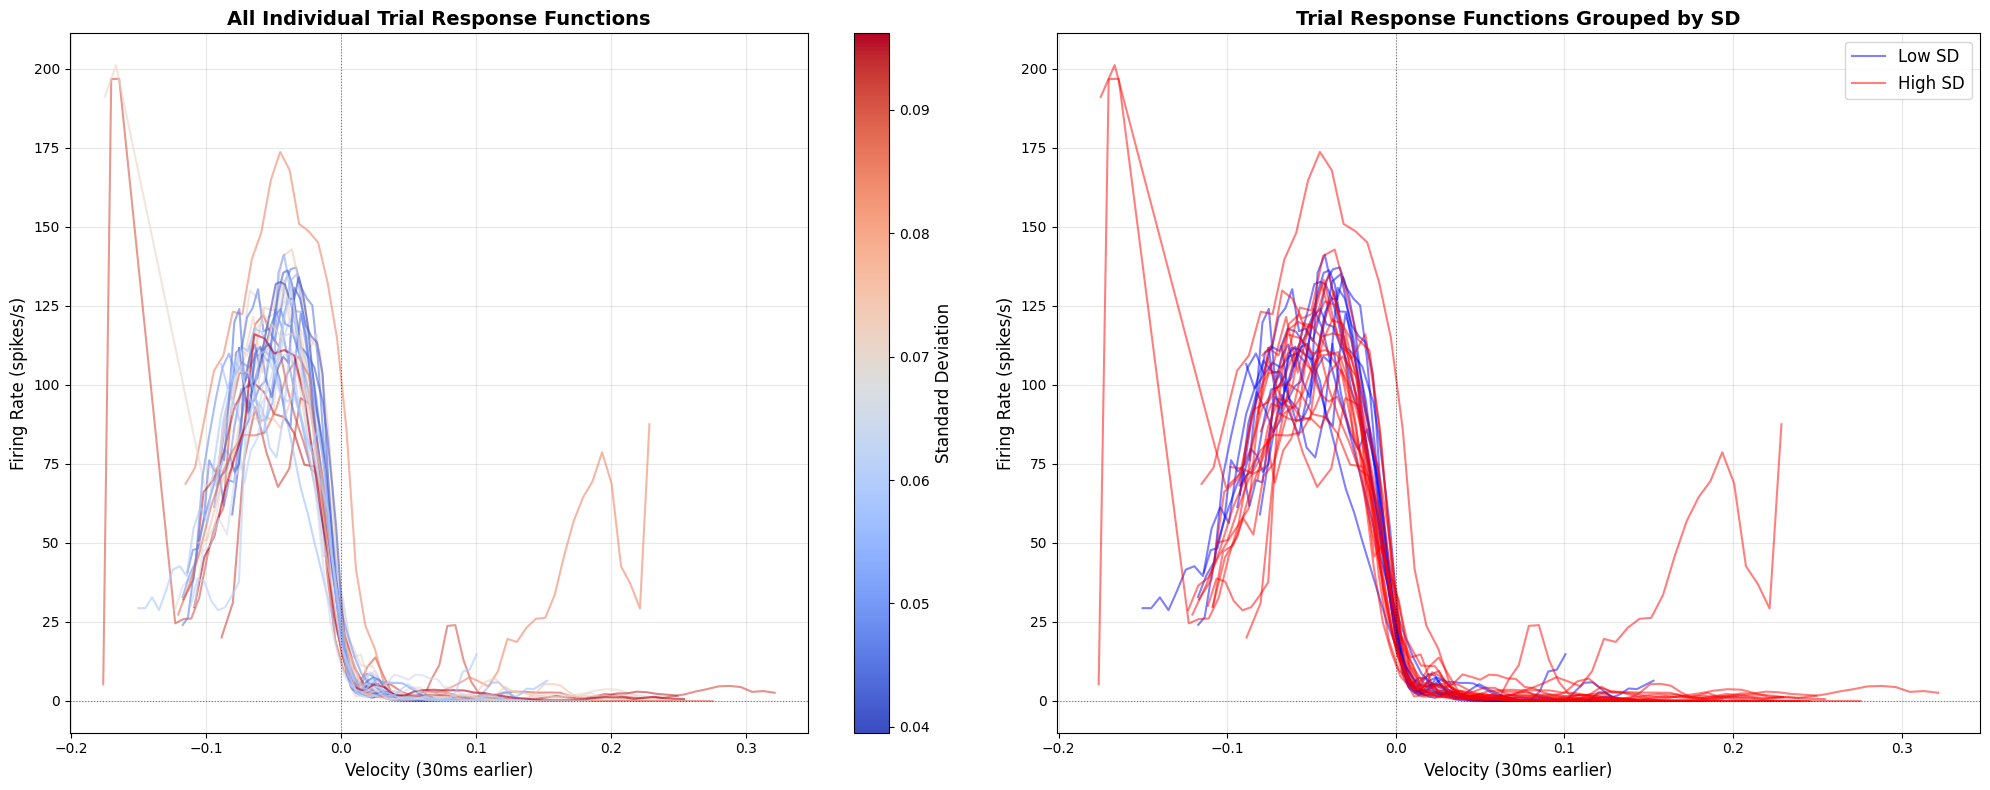


Trial-by-Trial Summary:
----------------------------------------------------------------------
Trial  1: SD = 0.073387  [HIGH SD]
Trial  2: SD = 0.090333  [HIGH SD]
Trial  3: SD = 0.091414  [HIGH SD]
Trial  4: SD = 0.084511  [HIGH SD]
Trial  5: SD = 0.069446  [HIGH SD]
Trial  6: SD = 0.070761  [HIGH SD]
Trial  7: SD = 0.046379  [LOW SD]
Trial  8: SD = 0.074625  [HIGH SD]
Trial  9: SD = 0.070891  [HIGH SD]
Trial 10: SD = 0.052226  [LOW SD]
Trial 11: SD = 0.050527  [LOW SD]
Trial 12: SD = 0.067919  [HIGH SD]
Trial 13: SD = 0.093555  [HIGH SD]
Trial 14: SD = 0.049341  [LOW SD]
Trial 15: SD = 0.042776  [LOW SD]
Trial 16: SD = 0.054857  [LOW SD]
Trial 17: SD = 0.061001  [HIGH SD]
Trial 18: SD = 0.039531  [LOW SD]
Trial 19: SD = 0.042348  [LOW SD]
Trial 20: SD = 0.046820  [LOW SD]
Trial 21: SD = 0.072575  [HIGH SD]
Trial 22: SD = 0.087629  [HIGH SD]
Trial 23: SD = 0.056497  [LOW SD]
Trial 24: SD = 0.045054  [LOW SD]
Trial 25: SD = 0.075215  [HIGH SD]
Trial 26: SD = 0.065241  [HIGH SD]
Trial

In [173]:
# Plot individual trial response functions with SD annotations
print("="*70)
print("INDIVIDUAL TRIAL RESPONSE FUNCTIONS")
print("="*70)

# Parameters
response_delay_ms = 30
delay_samples = int((response_delay_ms / 1000) * fs)
n_bins = 50

# Function to compute binned response for a single trial
def compute_trial_response_function(trial_num):
    """Compute binned response function for a single trial"""
    trial_idx = trial_num - 1
    start = manual_trial_starts[trial_idx]
    end = manual_trial_ends[trial_idx]
    
    trial_velocity = bipolar_signal[start:end]
    trial_firing_rate = firing_rate[start:end]
    
    # Align with delay
    velocity_aligned = trial_velocity[:-delay_samples]
    response_aligned = trial_firing_rate[delay_samples:]
    
    # Bin the data
    velocity_bins = np.linspace(velocity_aligned.min(), velocity_aligned.max(), n_bins + 1)
    response_binned = []
    velocity_centers = []
    
    for i in range(n_bins):
        mask = (velocity_aligned >= velocity_bins[i]) & (velocity_aligned < velocity_bins[i+1])
        n_points = np.sum(mask)
        
        if n_points > 50:  # Lower threshold for single trials
            response_binned.append(np.mean(response_aligned[mask]))
            velocity_centers.append((velocity_bins[i] + velocity_bins[i+1]) / 2)
    
    return np.array(velocity_centers), np.array(response_binned)

# Create color map based on SD values
from matplotlib import cm
from matplotlib.colors import Normalize

# Normalize SD values for colormap
norm = Normalize(vmin=sd_values.min(), vmax=sd_values.max())
cmap = cm.get_cmap('coolwarm')  # Blue for low SD, red for high SD

# Create figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot all trials
for i, trial_num in enumerate(trial_indices):
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    # Compute response function for this trial
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:  # Only plot if we have data
        color = cmap(norm(sd))
        
        # Panel 1: All trials
        ax1.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.6, color=color,
                label=f'Trial {trial_num}' if i < 5 else '')  # Only label first 5 to avoid clutter

# Add colorbar to panel 1
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax1)
cbar1.set_label('Standard Deviation', fontsize=12)

ax1.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax1.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax1.set_title('All Individual Trial Response Functions', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax1.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

# Panel 2: Separate by group
for trial_num in low_sd_trials:
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:
        ax2.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.5, color='blue',
                label='Low SD' if trial_num == low_sd_trials[0] else '')

for trial_num in high_sd_trials:
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    
    vel_centers, resp_binned = compute_trial_response_function(trial_num)
    
    if len(vel_centers) > 0:
        ax2.plot(vel_centers, resp_binned, linewidth=1.5, alpha=0.5, color='red',
                label='High SD' if trial_num == high_sd_trials[0] else '')

ax2.set_xlabel('Velocity (30ms earlier)', fontsize=12)
ax2.set_ylabel('Firing Rate (spikes/s)', fontsize=12)
ax2.set_title('Trial Response Functions Grouped by SD', fontsize=14, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)
ax2.axvline(0, color='black', linestyle=':', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.savefig('individual_trial_response_functions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary with SD values
print("\nTrial-by-Trial Summary:")
print("-" * 70)
for trial_num in sorted(trial_indices):
    trial_idx = trial_num - 1
    sd = sd_values[trial_idx]
    group = "LOW SD" if trial_num in low_sd_trials else "HIGH SD"
    print(f"Trial {trial_num:2d}: SD = {sd:.6f}  [{group}]")

print("\n✅ Individual trial response functions complete!")
print("  Saved to: individual_trial_response_functions.png")
print("="*70)